# Setup and Imports

In [2]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
import logging
import tpvalidator.mcprod.workspace as workspace
import tpvalidator.utilities as utils
import tpvalidator.mcprod.analyzers.snn as snn

from rich import print
from tpvalidator.utilities import temporary_log_level, pandas_backend

# Code

In [8]:
from typing import Tuple, Optional, Union, Sequence, Dict, List
from rich.table import Table
import tpvalidator.mcprod.geometry as dunegeo


def make_rates_table( datasets : Dict[str,pd.DataFrame], preselection: str, per:str='chan', title: str='') -> Table:
    """
    """
    
    # Constants : move them somewhere else
    ro_win = 8500
    sampling_period = 0.5e-6
    num_crps = 12

    def num_el_chans(v: int):
        return dunegeo.crp_num_chans_by_view_sim[v]*num_crps
    
    def num_el_crps(v: int):
        return num_crps
    
    def num_el_tpcs(v: int):
        return 48

    def num_el_det(v: int):
        return 1
    
    match per:
        case 'chan':
            num_el = num_el_chans
        case 'crp':
            num_el = num_el_crps
        case 'tpc':
            num_el = num_el_tpcs
        case 'det':
            num_el = num_el_det
        case _:
            raise RuntimeError(f"per value '{per}' not supported")

    t = Table('sample', 'time', 'U', 'V', 'X', title=title)
    for s, ws in datasets.items():
        num_ev = ws.num_events
        total_time = num_ev*ro_win*sampling_period
        row = [s, f'{total_time} s']
        tps_noise = ws.tps.query(preselection)
        for v in range(3):
            # num_els = dunegeo.crp_num_chans_by_view_sim[v]*num_crps
            num_els = num_el(v)
            noise_rate = len(tps_noise.query(f'readout_view == {v}'))/total_time/num_els
            row += [f'{noise_rate:.2f} Hz']
        t.add_row(*row)
    return t

In [9]:

def draw_bt_eff_by_plane(ws, rop_id, ax):
    tot_nel_df = ws.event_summary[['event', f'tot_numelectrons_rop{rop_id}']].set_index('event')
    bt_nel_df = pd.DataFrame(ws.tps.query(f'bt_is_signal == 1 & readout_plane_id == {rop_id}').groupby('event').bt_numelectrons.sum())
    eff_df = tot_nel_df.merge(bt_nel_df, how='inner', on='event').fillna(0)
    eff_df['ratio'] = eff_df.bt_numelectrons/eff_df[f'tot_numelectrons_rop{rop_id}']
    eff_df.ratio.hist(ax=ax)
    return eff_df


# Dataset loading and preparation

In [6]:
from pathlib import Path
pre_prod_dir = Path('../../data/vd/mini_prod/')

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    mu_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'vd_1x8x6_muminus_center_2333393_ana_evfix.ntuple.root')

# mu_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_muminus.root')
print(mu_ws.info)

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    em_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'vd_1x8x6_eminus_center_2333289_ana_evfix.ntuple.root')

# em_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_eminus.root')
print(em_ws.info)

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    gm_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'vd_1x8x6_gamma_center_2333392_ana_evfix.ntuple.root')

# gm_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_gamma.root')
print(gm_ws.info)


# with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
#     ar39_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_ar39_hist.root')

# ar39_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_ar39.root')

# print(ar39_ws.info)


# with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
#     rad_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_radiols_hist.root')
# rad_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_radiols.root')

# print(rad_ws.info)


datasets = {
    'e-minus': em_ws,
    'gamma': gm_ws,
    'mu-minus': mu_ws,
    # 'ar39': ar39_ws,
    # 'radiols': rad_ws
}

None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

# Signal and noise distribution - comparison among datasets

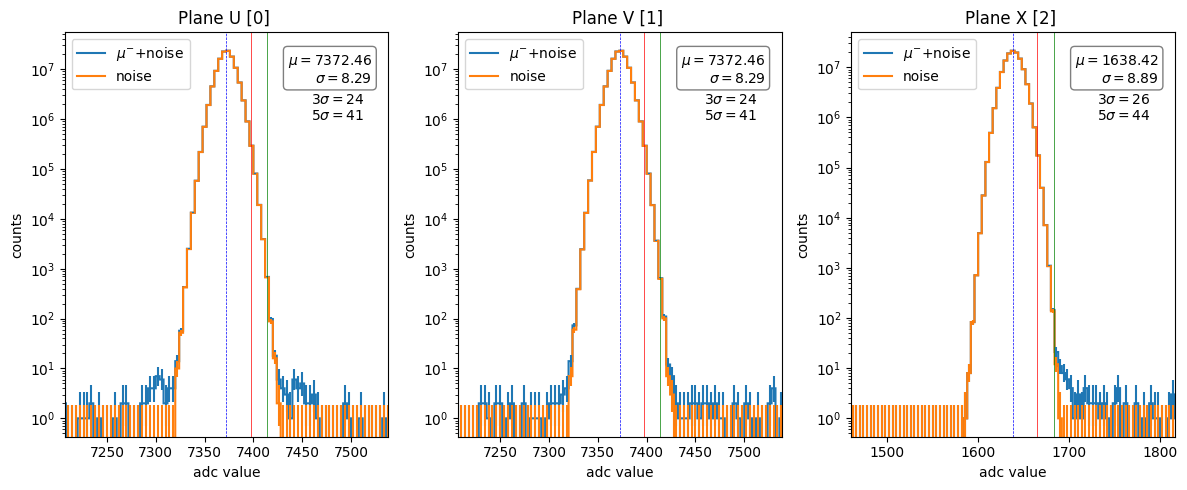

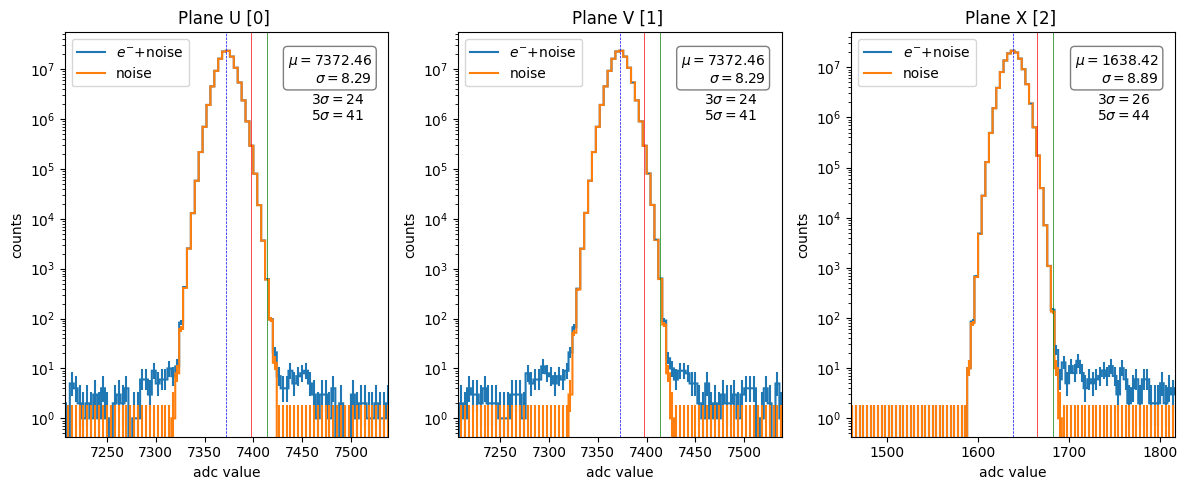

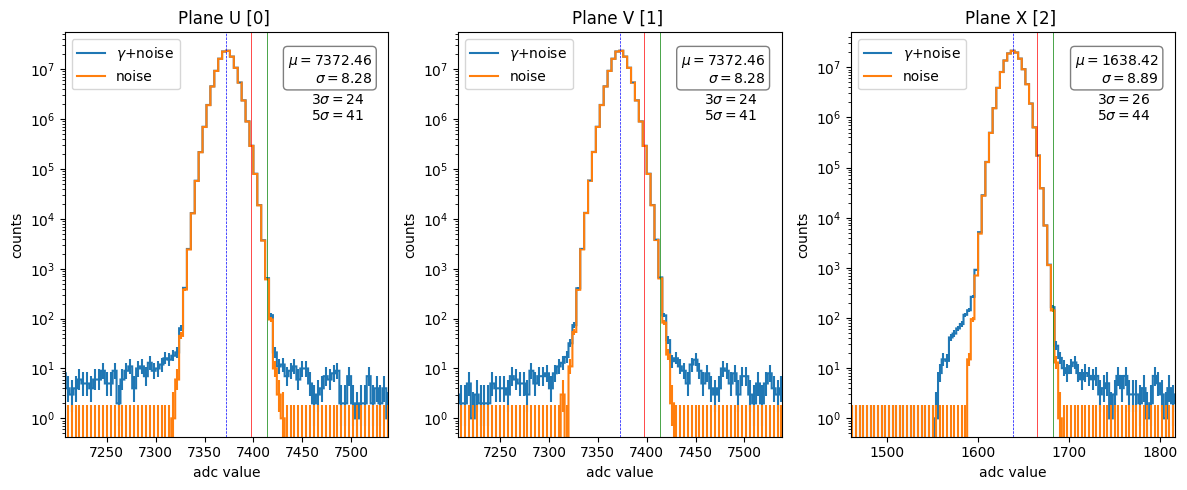

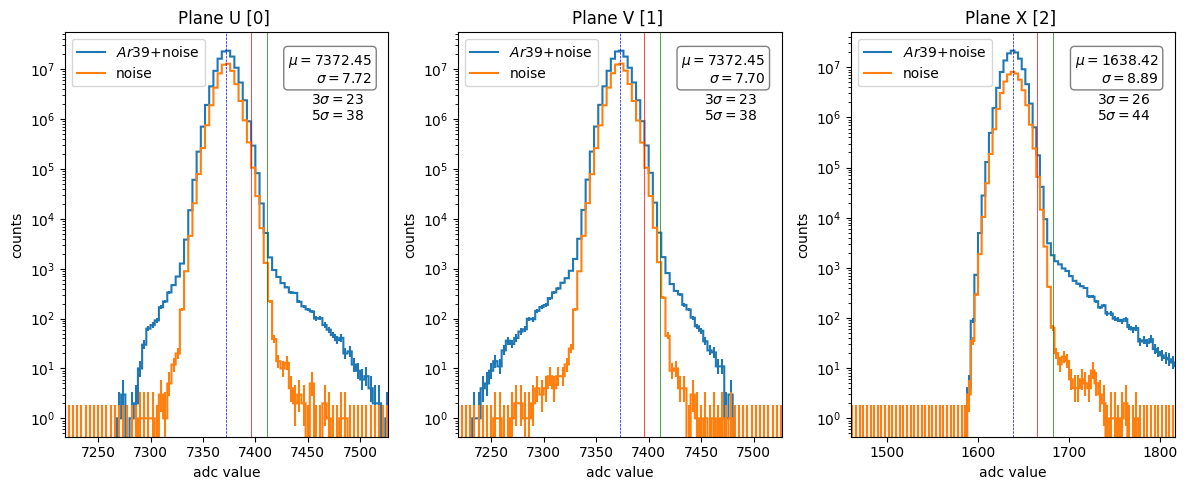

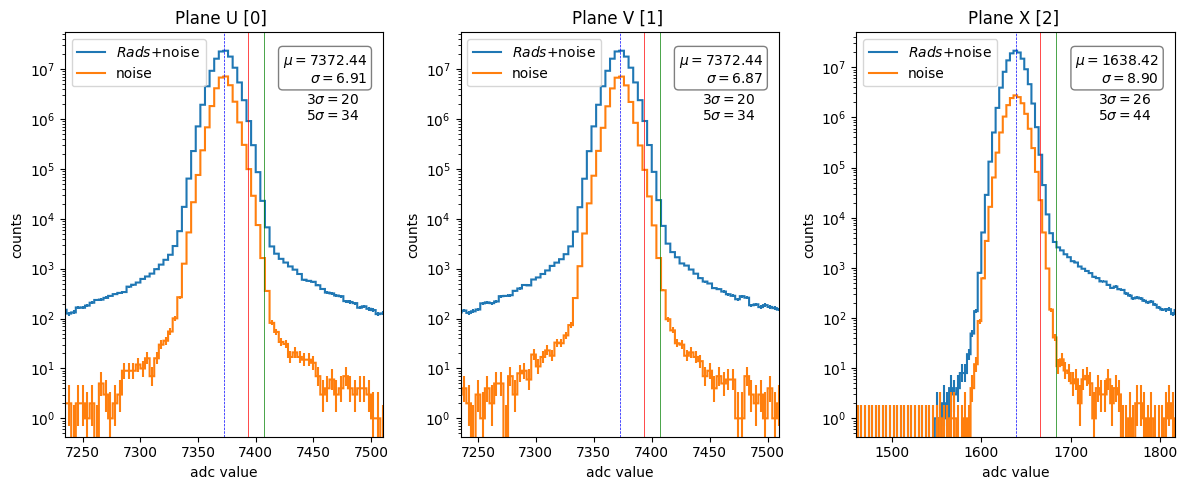

In [ ]:
_ = snn.draw_signal_and_noise_adc_distros(mu_ws, signal_label=r"$\mu^{-}$")
_ = snn.draw_signal_and_noise_adc_distros(em_ws, signal_label=r"$e^{-}$")
_ = snn.draw_signal_and_noise_adc_distros(gm_ws, signal_label=r"$\gamma$")
# _ = snn.draw_signal_and_noise_adc_distros(ar39_ws, signal_label=r"$Ar39$")
# _ = snn.draw_signal_and_noise_adc_distros(rad_ws, signal_label=r"$Rads$")


# Noise TP rates

In [11]:
print(make_rates_table(datasets, 'bt_is_signal == 0', title='noise TP rates'))
print(make_rates_table(datasets, 'bt_is_signal == 1', title='signal TP rates'))

                         noise TP rates                          
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ sample   ┃ time                 ┃ U       ┃ V       ┃ X       ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ e-minus  │ 20.91 s              │ 0.72 Hz │ 0.71 Hz │ 0.29 Hz │
│ gamma    │ 21.037499999999998 s │ 0.72 Hz │ 0.70 Hz │ 0.29 Hz │
│ mu-minus │ 20.9525 s            │ 0.72 Hz │ 0.70 Hz │ 0.29 Hz │
└──────────┴──────────────────────┴─────────┴─────────┴─────────┘

                         signal TP rates                         
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ sample   ┃ time                 ┃ U       ┃ V       ┃ X       ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ e-minus  │ 20.91 s              │ 0.38 Hz │ 0.37 Hz │ 0.44 Hz │
│ gamma    │ 21.037499999999998 s │ 0.35 Hz │ 0.34 Hz │ 0.41 Hz │
│ mu-minus │ 20.9525 s            │ 0.32 Hz │ 0.31 Hz │ 0.38 Hz │
└──────────┴──────────────────────┴─────────┴─────────┴─────────┘

In [12]:
print(make_rates_table(datasets, 'bt_is_signal == 0', 'det', title='noise TP rates'))
print(make_rates_table(datasets, 'bt_is_signal == 1', 'det', title='signal TP rates'))

                              noise TP rates                              
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ sample   ┃ time                 ┃ U          ┃ V          ┃ X          ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ e-minus  │ 20.91 s              │ 9895.89 Hz │ 9695.55 Hz │ 4105.60 Hz │
│ gamma    │ 21.037499999999998 s │ 9858.35 Hz │ 9677.24 Hz │ 4095.12 Hz │
│ mu-minus │ 20.9525 s            │ 9906.79 Hz │ 9668.63 Hz │ 4132.44 Hz │
└──────────┴──────────────────────┴────────────┴────────────┴────────────┘

                             signal TP rates                              
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ sample   ┃ time                 ┃ U          ┃ V          ┃ X          ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ e-minus  │ 20.91 s              │ 5192.49 Hz │ 5095.93 Hz │ 6153.56 Hz │
│ gamma    │ 21.037499999999998 s │ 4834.37 Hz │ 4643.33 Hz │ 5790.61 Hz │
│ mu-minus │ 20.9525 s            │ 4357.52 Hz │ 4219.93 Hz │ 5288.87 Hz │
└──────────┴──────────────────────┴────────────┴────────────┴────────────┘

In [13]:
print(make_rates_table(datasets, 'bt_is_signal == 0 & samples_over_threshold > 8', title='noise TP rates'))
print(make_rates_table(datasets, 'bt_is_signal == 1 & samples_over_threshold > 8', title='signal TP rates'))

                         noise TP rates                          
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ sample   ┃ time                 ┃ U       ┃ V       ┃ X       ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ e-minus  │ 20.91 s              │ 0.00 Hz │ 0.00 Hz │ 0.00 Hz │
│ gamma    │ 21.037499999999998 s │ 0.00 Hz │ 0.00 Hz │ 0.00 Hz │
│ mu-minus │ 20.9525 s            │ 0.00 Hz │ 0.00 Hz │ 0.00 Hz │
└──────────┴──────────────────────┴─────────┴─────────┴─────────┘

                         signal TP rates                         
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ sample   ┃ time                 ┃ U       ┃ V       ┃ X       ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ e-minus  │ 20.91 s              │ 0.22 Hz │ 0.28 Hz │ 0.35 Hz │
│ gamma    │ 21.037499999999998 s │ 0.20 Hz │ 0.24 Hz │ 0.32 Hz │
│ mu-minus │ 20.9525 s            │ 0.18 Hz │ 0.23 Hz │ 0.29 Hz │
└──────────┴──────────────────────┴─────────┴─────────┴─────────┘

# Signal and noise TP distributions

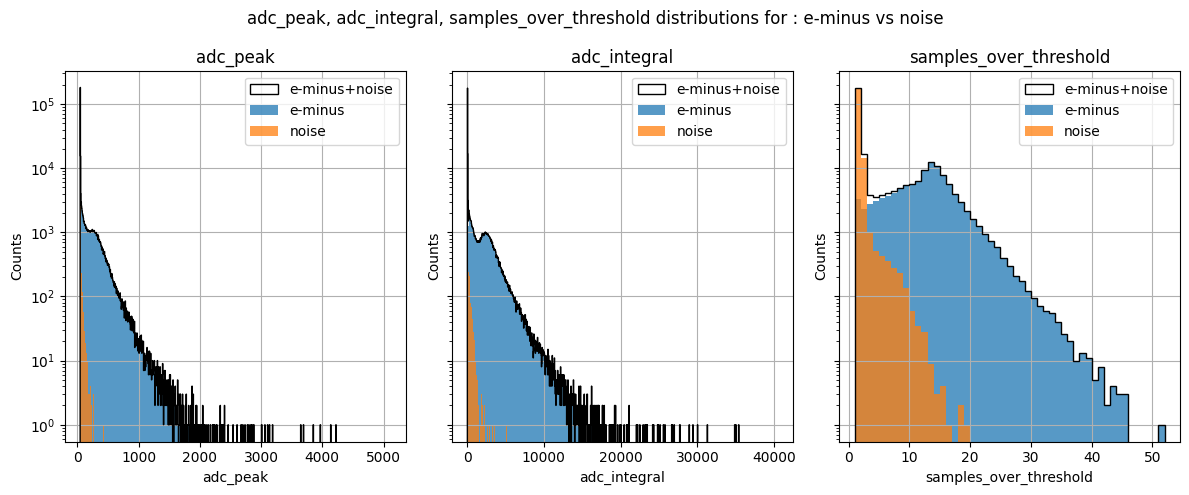

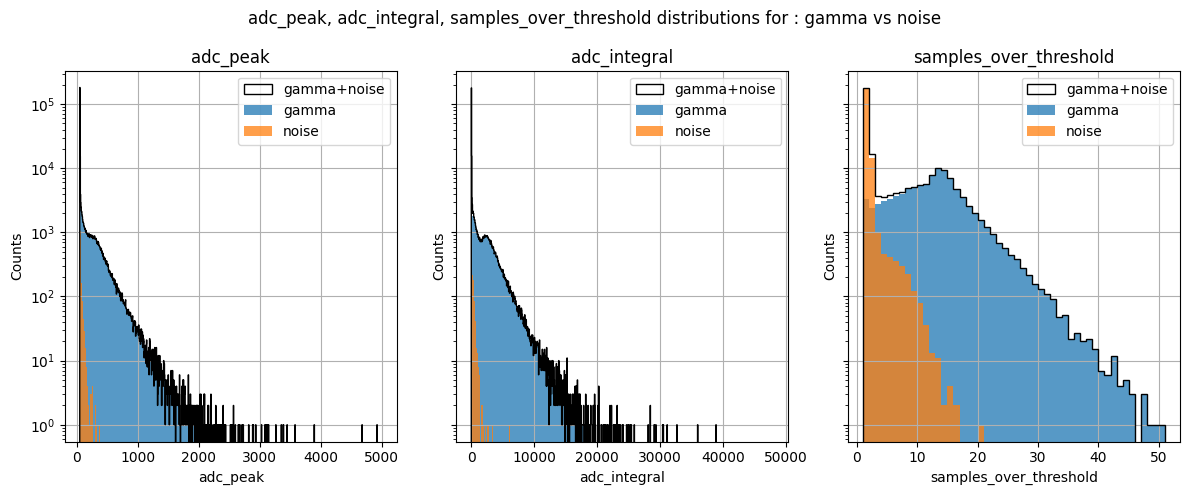

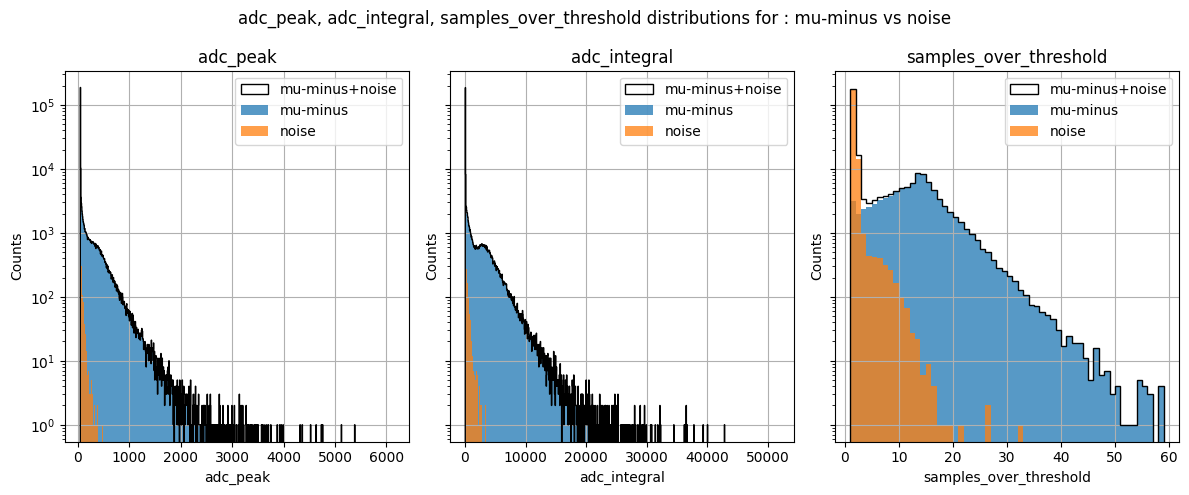

In [14]:
for n, ws in datasets.items():
    tp_sel = snn.TPSignalNoiseSelector(ws.tps[(ws.tps.sample_start >100) & (ws.tps.sample_start <8100)])
    tp_ana = snn.TPSignalNoiseAnalyzer(tp_sel, signal_name = n)
    fig = tp_ana.draw_tp_signal_noise_dist(roview=1)


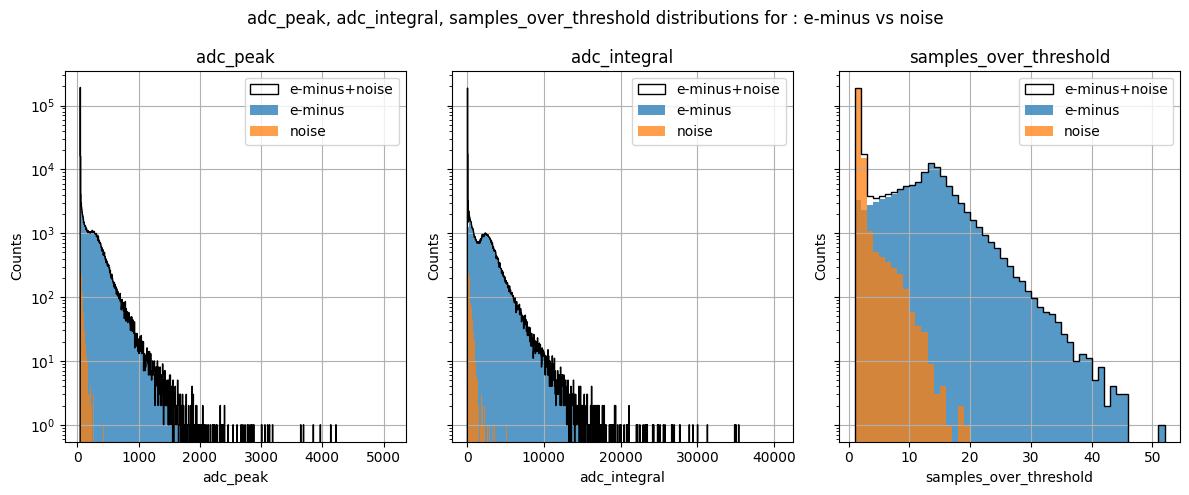

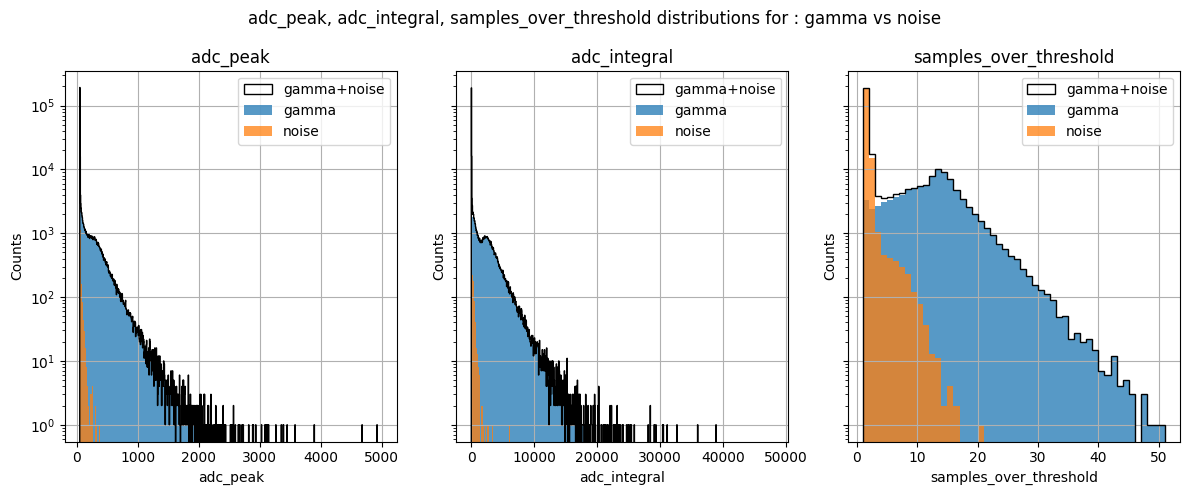

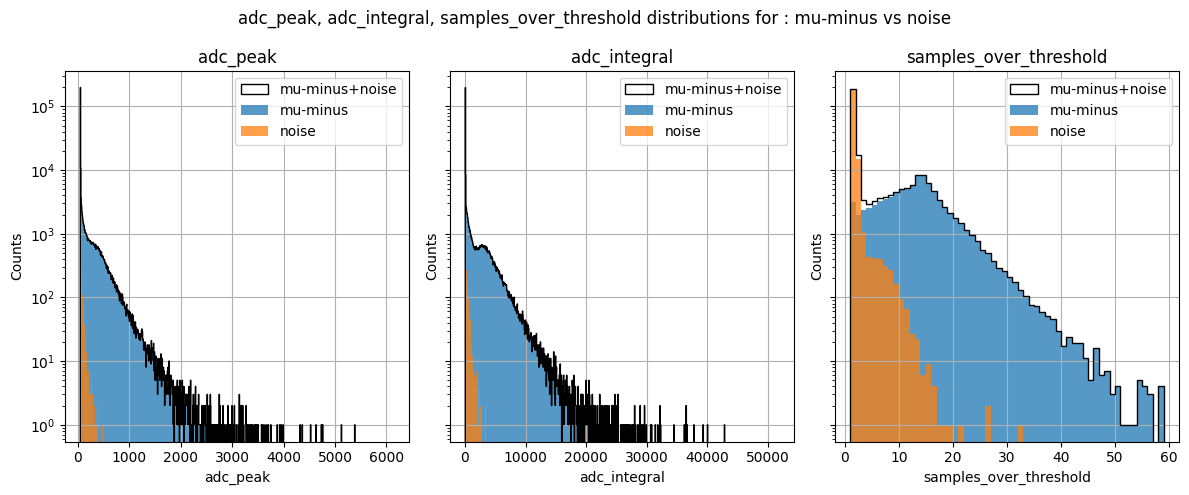

In [15]:
for n, ws in datasets.items():
    tp_sel = snn.TPSignalNoiseSelector(ws.tps)
    tp_ana = snn.TPSignalNoiseAnalyzer(tp_sel, signal_name = n)
    fig = tp_ana.draw_tp_signal_noise_dist(roview=1)


# TP origin in the detector

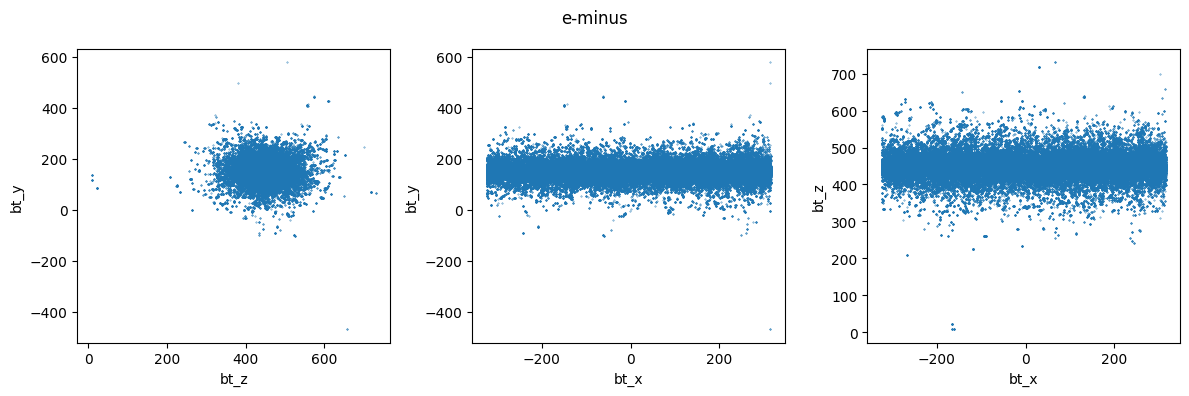

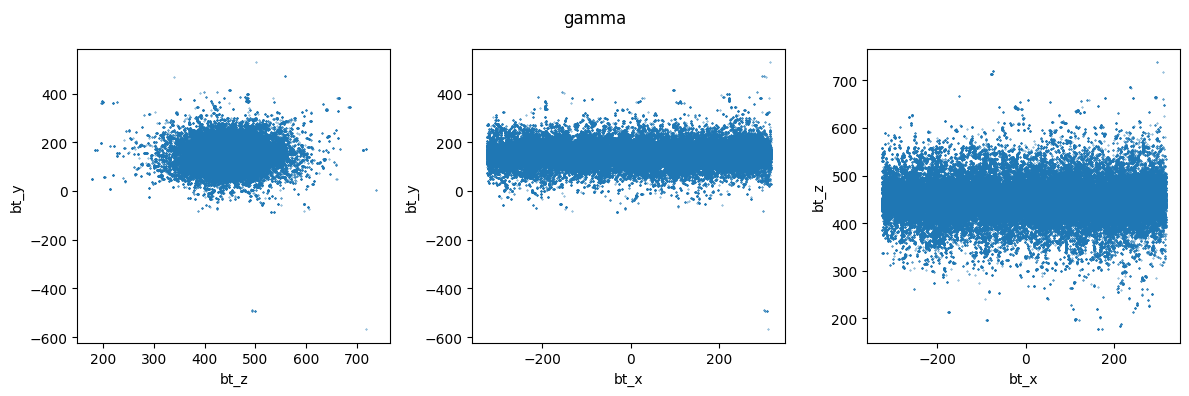

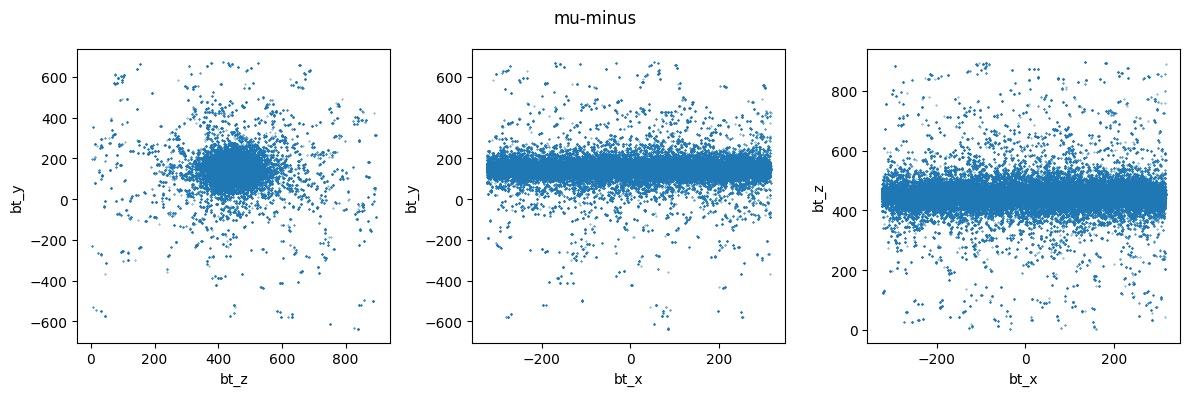

In [16]:
for n, ws in datasets.items():
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    ax=axes[0]
    ws.tps.query('bt_is_signal').plot.scatter(x='bt_z', y='bt_y', ax=ax, s=0.1)
    ax=axes[1]
    ws.tps.query('bt_is_signal').plot.scatter(x='bt_x', y='bt_y', ax=ax, s=0.1)
    ax=axes[2]
    ws.tps.query('bt_is_signal').plot.scatter(x='bt_x', y='bt_z', ax=ax, s=0.1)
    fig.suptitle(n)
    fig.tight_layout()

# Backtracking coverage

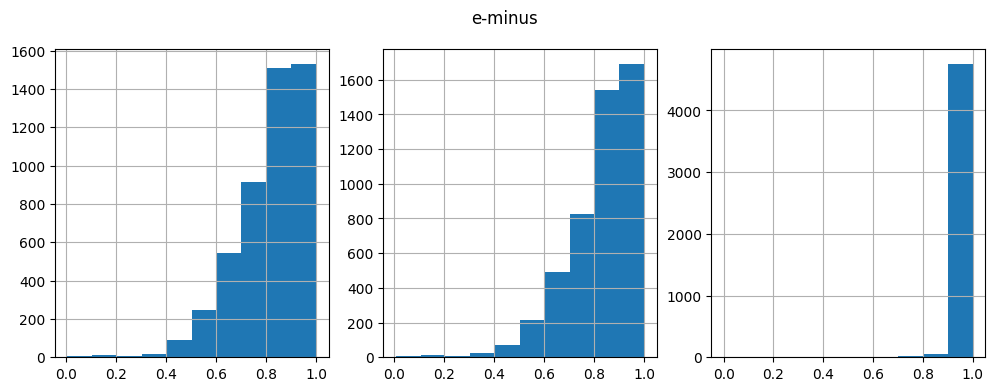

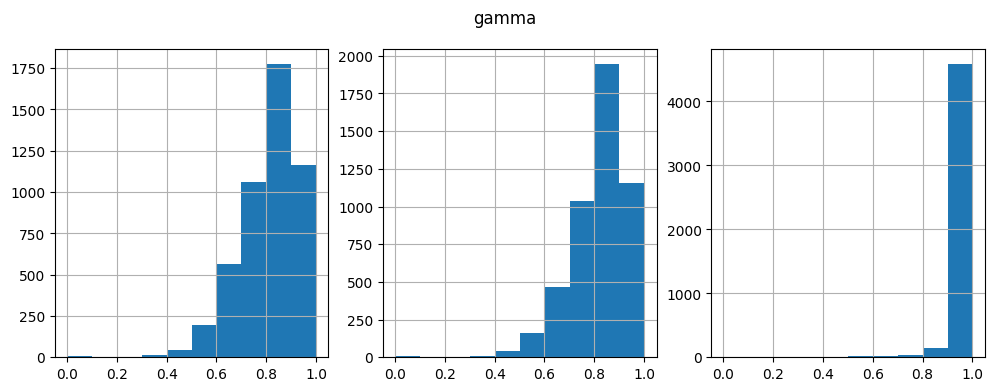

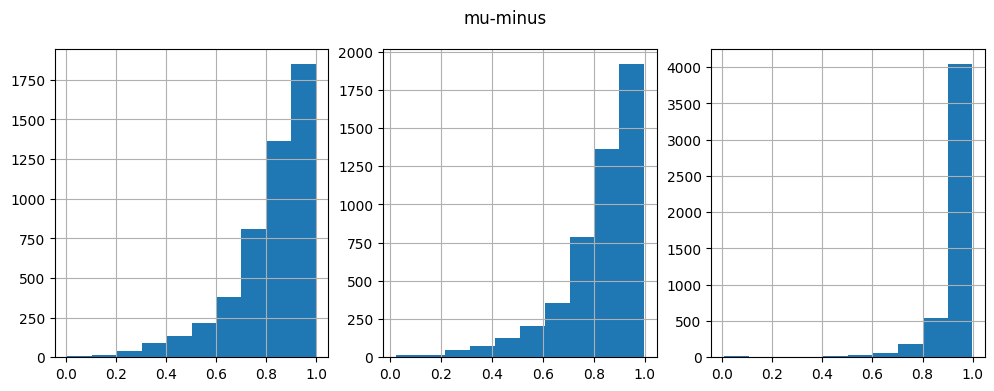

In [17]:
for n, ws in datasets.items():
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    em_0_df = draw_bt_eff_by_plane(ws, 0, axes[0])
    em_1_df = draw_bt_eff_by_plane(ws, 1, axes[1])
    em_2_df = draw_bt_eff_by_plane(ws, 2, axes[2])
    fig.suptitle(n)

# Others


TPs view 0 : 6561, signal=2290, noise=4271

TPs view 1 : 3567, signal=2055, noise=1512

TPs view 2 : 3148, signal=2629 noise=519

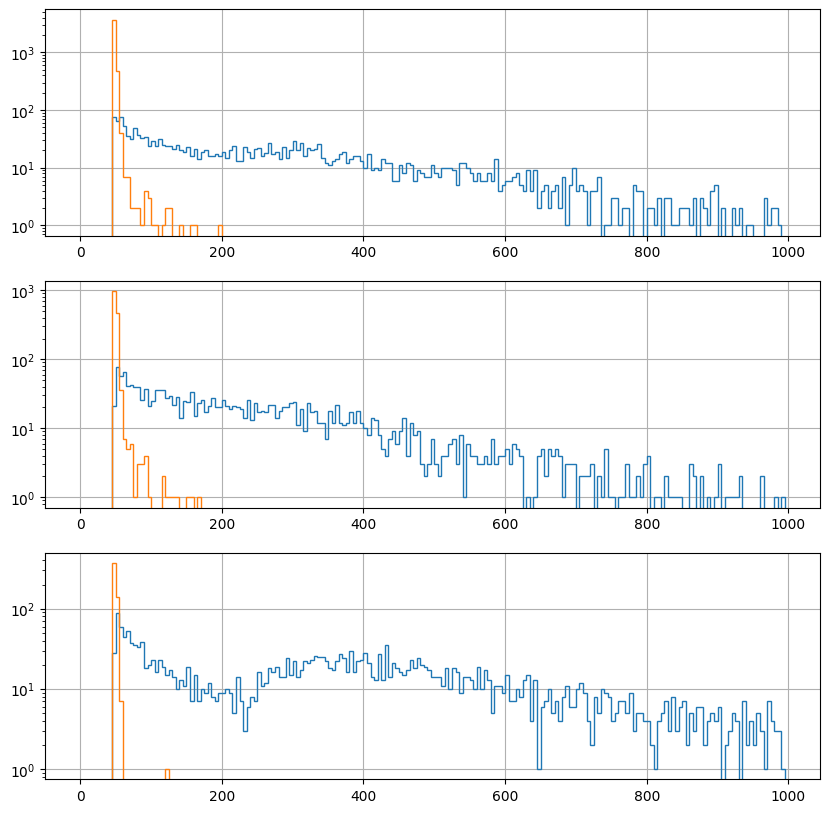

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(10,10), squeeze=False)

bins_sot=list(range(0,45))
bins_peak=list(range(0,1000, 5))

ws = em_ws
tps_p0 = ws.tps.query(f'readout_view==0 & adc_peak > 44')
print(f"TPs view 0 : {len(tps_p0)}, signal={len(tps_p0.query('bt_is_signal==1'))}, noise={len(tps_p0.query('bt_is_signal==0'))}")

ax=axes[0,0]
# tps_p0.query('bt_is_signal').samples_over_threshold.hist(ax=ax, bins=bins_sot, histtype='step')
# tps_p0.query('bt_is_signal == 0').samples_over_threshold.hist(ax=ax, bins=bins_sot, histtype='step')
# ax.set_yscale('log')

# ax=axes[0,1]
# bins=list(range(0,40000, 400))
# # bins=None
# tps_p0.query('bt_is_signal').adc_integral.hist(ax=ax, bins=bins, histtype='step')
# tps_p0.query('bt_is_signal == 0').adc_integral.hist(ax=ax, bins=bins, histtype='step')
# ax.set_yscale('log')

# ax=axes[0,2]
bins=list(range(0,7500, 150))
# bins=None
tps_p0.query('bt_is_signal').adc_peak.hist(ax=ax, bins=bins_peak, histtype='step')
tps_p0.query('bt_is_signal == 0').adc_peak.hist(ax=ax, bins=bins_peak, histtype='step')
ax.set_yscale('log')

tps_p1 = ws.tps.query(f'readout_view==1 & adc_peak > 47')
print(f"TPs view 1 : {len(tps_p1)}, signal={len(tps_p1.query('bt_is_signal==1'))}, noise={len(tps_p1.query('bt_is_signal==0'))}")

ax=axes[1,0]
# bins=list(range(0,40))
# tps_p1.query('bt_is_signal').samples_over_threshold.hist(ax=ax, bins=bins_sot)
# tps_p1.query('bt_is_signal == 0').samples_over_threshold.hist(ax=ax, bins=bins_sot)
# ax.set_yscale('log')

# ax=axes[1,1]
# bins=list(range(0,40000, 400))
# # bins=None
# tps_p1.query('bt_is_signal').adc_integral.hist(ax=ax, bins=bins)
# tps_p1.query('bt_is_signal == 0').adc_integral.hist(ax=ax, bins=bins)
# ax.set_yscale('log')

# ax=axes[1,2]
# bins=list(range(0,7500, 150))
# bins=None
tps_p1.query('bt_is_signal').adc_peak.hist(ax=ax, bins=bins_peak, histtype='step')
tps_p1.query('bt_is_signal == 0').adc_peak.hist(ax=ax, bins=bins_peak, histtype='step')
ax.set_yscale('log')



tps_p2 = ws.tps.query(f'readout_view==2 & adc_peak > 47')
print(f"TPs view 2 : {len(tps_p2)}, signal={len(tps_p2.query('bt_is_signal==1'))} noise={len(tps_p2.query('bt_is_signal==0'))}")

ax=axes[2,0]
# bins=list(range(0,40))
# tps_p2.query('bt_is_signal').samples_over_threshold.hist(ax=ax, bins=bins_sot)
# tps_p2.query('bt_is_signal == 0').samples_over_threshold.hist(ax=ax, bins=bins_sot)
# ax.set_yscale('log')

# ax=axes[2,1]
# bins=list(range(0,40000, 400))
# # bins=None
# tps_p2.query('bt_is_signal').adc_integral.hist(ax=ax, bins=bins)
# tps_p2.query('bt_is_signal == 0').adc_integral.hist(ax=ax, bins=bins)
# ax.set_yscale('log')

# ax=axes[2,2]
bins=list(range(0,7500, 150))
# bins=None
tps_p2.query('bt_is_signal').adc_peak.hist(ax=ax, bins=bins_peak, histtype='step')
tps_p2.query('bt_is_signal == 0').adc_peak.hist(ax=ax, bins=bins_peak, histtype='step')
ax.set_yscale('log')

In [21]:
ws.tps

,event,run,subrun,version,flag,detid,channel,samples_over_threshold,time_start,samples_to_peak,...,bt_z,bt_primary_x,bt_primary_y,bt_primary_z,bt_truth_block_id,bt_generator_name,time_peak,sample_start,sample_peak,bt_is_signal
0,1,20000011,0,2,0,3,187,2,262400,1,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999,,262464,8200,8202,False
1,1,20000011,0,2,0,3,193,1,262400,0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999,,262432,8200,8201,False
2,1,20000011,0,2,0,3,968,1,164384,0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999,,164416,5137,5138,False
3,1,20000011,0,2,0,3,991,1,10592,0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999,,10624,331,332,False
4,1,20000011,0,2,0,3,1004,1,266304,0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999,,266336,8322,8323,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17309,100,20000011,0,2,0,3,38969,1,19488,0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999,,19520,609,610,False
17310,100,20000011,0,2,0,3,38992,1,11680,0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999,,11712,365,366,False
17311,100,20000011,0,2,0,3,40173,2,235744,0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999,,235808,7367,7369,False
17312,100,20000011,0,2,0,3,40708,1,237280,0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999,,237312,7415,7416,False
